In [1]:
# %pip install seaborn
%pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import nltk

In [3]:
# Azure Machine Learning workspace details:
subscription = '58bb8a15-5d27-4d02-a5ca-772d24ae37a8'
resource_group = 'project-rg'
workspace = 'group-02-aml'
datastore_name = 'workspaceblobstore'
path_on_datastore = 'filtered-submissions-all2'

# long-form Datastore uri format:
uri = f'azureml://subscriptions/{subscription}/resourcegroups/{resource_group}/workspaces/{workspace}/datastores/{datastore_name}'
print(uri)
print(path_on_datastore)

azureml://subscriptions/58bb8a15-5d27-4d02-a5ca-772d24ae37a8/resourcegroups/project-rg/workspaces/group-02-aml/datastores/workspaceblobstore
filtered-submissions-all2


In [18]:
import pandas as pd
from azureml.fsspec import AzureMachineLearningFileSystem

# create the filesystem
fs = AzureMachineLearningFileSystem(uri)

# append parquet files in folder to a list
dflist = []
for path in fs.glob(f'{path_on_datastore}/*.parquet'):
    with fs.open(path) as f:
        dflist.append(pd.read_parquet(f))

# concatenate data frames
reddit_df = pd.concat(dflist)

# Data Cleaning

In [6]:
# check for null values
cols_to_drop = []
for i in reddit_df.columns:
    print(i, '\t\t\t', reddit_df[i].isna().sum(), reddit_df[i].isna().sum()/len(reddit_df))
    if (reddit_df[i].isna().sum()/len(reddit_df)) > .90:
        cols_to_drop.append(i)

adserver_click_url 			 217394 1.0
adserver_imp_pixel 			 217394 1.0
archived 			 0 0.0
author 			 0 0.0
author_cakeday 			 216628 0.9964764436920982
author_flair_css_class 			 199912 0.9195837971609152
author_flair_text 			 196185 0.9024398097463592
author_id 			 217394 1.0
brand_safe 			 217394 1.0
contest_mode 			 0 0.0
created_utc 			 0 0.0
crosspost_parent 			 209795 0.9650450334415853
crosspost_parent_list 			 209795 0.9650450334415853
disable_comments 			 217394 1.0
distinguished 			 216232 0.9946548662796582
domain 			 1880 0.0086478927661297
domain_override 			 217394 1.0
edited 			 0 0.0
embed_type 			 217394 1.0
embed_url 			 217394 1.0
gilded 			 0 0.0
hidden 			 0 0.0
hide_score 			 0 0.0
href_url 			 217394 1.0
id 			 0 0.0
imp_pixel 			 217394 1.0
is_crosspostable 			 0 0.0
is_reddit_media_domain 			 0 0.0
is_self 			 0 0.0
is_video 			 0 0.0
link_flair_css_class 			 130259 0.5991839701187706
link_flair_text 			 123324 0.5672833656862655
locked 			 0 0.0
media 			 202858 

In [8]:
reddit_df = reddit_df.drop(cols_to_drop, axis = 'columns')

In [9]:
reddit_df.describe()

,created_utc,gilded,num_comments,num_crossposts,retrieved_on,score,thumbnail_height,thumbnail_width
count,217394,217394.000000,217394.000000,217394.000000,169448,217394.000000,99174.000000,99174.000000
mean,2022-02-14 21:38:02.766203648,0.007015,20.465132,0.036689,2022-08-30 18:02:07.563754240,61.546064,101.353792,134.781697
min,2021-01-01 00:10:31,0.000000,0.000000,0.000000,2022-02-19 03:08:36,0.000000,0.000000,0.000000
25%,2021-07-25 07:23:40.500000,0.000000,0.000000,0.000000,2022-06-24 07:50:23.750000128,1.000000,78.000000,140.000000
50%,2022-02-14 02:56:00,0.000000,2.000000,0.000000,2022-06-26 01:46:35,1.000000,103.000000,140.000000
75%,2022-09-05 09:45:24,0.000000,14.000000,0.000000,2022-11-09 22:47:54.249999872,17.000000,140.000000,140.000000
max,2023-03-31 23:46:50,8.000000,5503.000000,73.000000,2023-04-09 07:21:52,57618.000000,140.000000,140.000000
std,NaN,0.094668,65.089161,0.360493,NaN,282.495090,33.220967,26.380477


In [10]:
reddit_df.subreddit.unique()

array(['washingtondc', 'Seattle', 'Atlanta', 'nyc'], dtype=object)

In [11]:
reddit_df.columns

Index(['archived', 'author', 'contest_mode', 'created_utc', 'domain', 'edited',
       'gilded', 'hidden', 'hide_score', 'id', 'is_crosspostable',
       'is_reddit_media_domain', 'is_self', 'is_video', 'link_flair_css_class',
       'link_flair_text', 'locked', 'media_embed', 'num_comments',
       'num_crossposts', 'over_18', 'parent_whitelist_status', 'permalink',
       'pinned', 'post_hint', 'preview', 'retrieved_on', 'score',
       'secure_media_embed', 'selftext', 'spoiler', 'stickied', 'subreddit',
       'subreddit_id', 'thumbnail', 'thumbnail_height', 'thumbnail_width',
       'title', 'url', 'whitelist_status'],
      dtype='object')

In [12]:
reddit_df['selftext'].head()

0                                            [deleted]
1                                            [removed]
2    I have dental insurance but it's only with gre...
3                                            [deleted]
4    From NWAC:\n\nWe’ve received preliminary infor...
Name: selftext, dtype: object

In [42]:
# separate submissions that were removed or deleted
removed_filter = (reddit_df.selftext == '[removed]') | reddit_df.selftext.str.contains('Removed by reddit ')
deleted_filter = (reddit_df.selftext == '[deleted]')
num_removed = len(reddit_df[removed_filter])
num_deleted = len(reddit_df[deleted_filter])
print(f"Num removed: {num_removed}")
print(f"Num deleted: {num_deleted}")
# remove those rows - save in another df in case its needed
removed_df = reddit_df[removed_filter | deleted_filter]
print(f"All rows: {len(reddit_df)}")
reddit_df = reddit_df[(~removed_filter) & (~deleted_filter)]
print(f"New num of rows: {len(reddit_df)}")

Num removed: 67672
Num deleted: 24059
All rows: 217394
New num of rows: 125663


In [38]:
removed_df.selftext.value_counts()

removed_df.num_comments.describe()

count    91731.000000
mean         4.997972
std         24.077914
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max       1276.000000
Name: num_comments, dtype: float64

In [103]:
for i in reddit_df.columns:
    print(reddit_df[i].head())

0    None
1    None
2    None
3    None
4    None
Name: adserver_click_url, dtype: object
0    None
1    None
2    None
3    None
4    None
Name: adserver_imp_pixel, dtype: object
0    False
1    False
2    False
3    False
4    False
Name: archived, dtype: bool
0               [deleted]
1               thewheisk
2    Adventurous_Emu_3359
3               [deleted]
4               hammer838
Name: author, dtype: object
0    None
1    None
2    None
3    None
4    None
Name: author_cakeday, dtype: object
0    None
1    None
2    None
3    None
4    None
Name: author_flair_css_class, dtype: object
0    None
1    None
2    None
3    None
4    None
Name: author_flair_text, dtype: object
0    None
1    None
2    None
3    None
4    None
Name: author_id, dtype: object
0    None
1    None
2    None
3    None
4    None
Name: brand_safe, dtype: object
0    False
1    False
2    False
3    False
4    False
Name: contest_mode, dtype: bool
0   2023-02-22 21:23:45
1   2023-02-22 21:25:33
2   2023-02-

In [93]:
reddit_df.title.head()

0          Should I move to D.C. or commute from NoVa?
1    ChatGPT - what should happen to a sitting memb...
2                              Dentist Recommendation?
3    Investigation: Seattle cop used police databas...
4    3 Backcountry travelers suspected to have died...
Name: title, dtype: object

In [101]:
list(reddit_df.url.head())

['',
 'https://www.reddit.com/r/Seattle/comments/119dxqq/chatgpt_what_should_happen_to_a_sitting_member_of/',
 'https://www.reddit.com/r/Atlanta/comments/119dy30/dentist_recommendation/',
 '',
 'https://www.reddit.com/r/Seattle/comments/117w1qz/3_backcountry_travelers_suspected_to_have_died_in/']

In [88]:
reddit_df.over_18.unique()

array([False,  True])

In [57]:
pd.to_datetime(reddit_df.loc[:, 'created_utc'].head())

0   2023-02-22 21:23:45
1   2023-02-21 04:56:55
2   2023-02-21 05:13:15
3   2023-02-21 05:16:03
4   2023-02-21 19:34:36
Name: created_utc, dtype: datetime64[ns]

In [43]:
reddit_df.loc[:, 'created_utc'] = pd.to_datetime(reddit_df.loc[:, 'created_utc'])
reddit_df.loc[:, 'created_date'] = pd.to_datetime(reddit_df.loc[:, 'created_utc'], format = '%Y-%m-%d')
reddit_df.loc[:, 'created_month'] = pd.to_datetime(pd.to_datetime(reddit_df.loc[:, 'created_date']).dt.year.astype(str)+'-'+pd.to_datetime(reddit_df.loc[:, 'created_date']).dt.month.astype(str)+'-01')

/tmp/ipykernel_12183/2734744016.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit_df.loc[:, 'created_date'] = pd.to_datetime(reddit_df.loc[:, 'created_utc'], format = '%Y-%m-%d')
/tmp/ipykernel_12183/2734744016.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit_df.loc[:, 'created_month'] = pd.to_datetime(pd.to_datetime(reddit_df.loc[:, 'created_date']).dt.year.astype(str)+'-'+pd.to_datetime(reddit_df.loc[:, 'created_date']).dt.month.astype(str)+'-01')


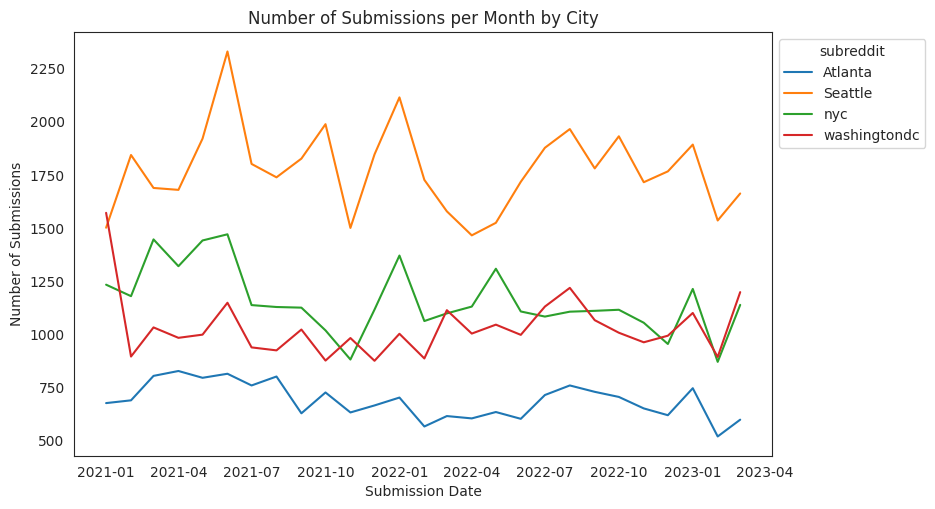

In [51]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(9,5.5))

group_date = reddit_df.groupby(['subreddit', 'created_month']).size().reset_index().rename({0:'count'}, axis='columns')
group_date.head()

sns.lineplot(x = 'created_month', y = 'count', hue = 'subreddit', data = group_date)
ax.set_title("Number of Submissions per Month by City")
ax.set_ylabel("Number of Submissions")
ax.set_xlabel("Submission Date")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


In [11]:
group_date.head()

,subreddit,created_month,count
0,Atlanta,2021-01-01,1397
1,Atlanta,2021-02-01,1356
2,Atlanta,2021-03-01,1509
3,Atlanta,2021-04-01,1579
4,Atlanta,2021-05-01,1547


Text(0.5, 1.0, 'Percent Change from Previous Month per City')

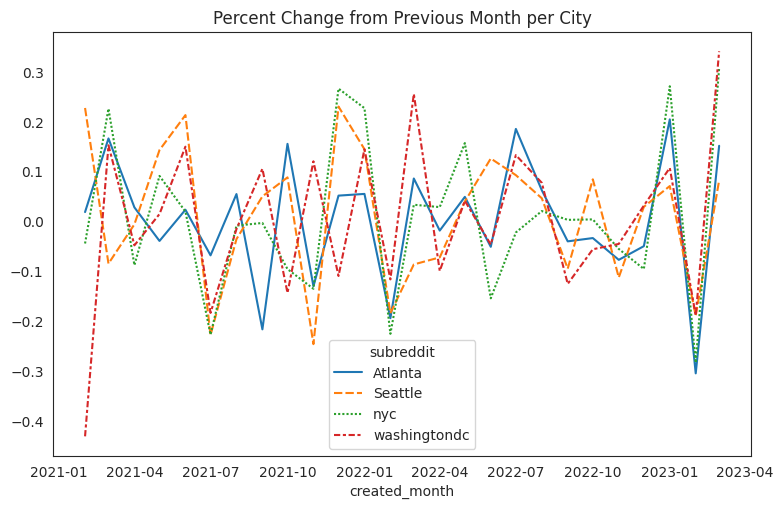

In [52]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(9,5.5))

# group_date.pct_change(periods = 'subreddit')

# group_date['count'].pct_change().fillna(0)
month_submissions = pd.pivot(group_date, values = 'count', index = 'created_month', columns = 'subreddit')
perc_change_submissions = month_submissions.pct_change()

sns.lineplot(perc_change_submissions)
ax.set_title("Percent Change from Previous Month per City")

# Regex One-Hot Encoded

In [53]:
reddit_df.loc[:,'airbnb_yes'] = reddit_df.loc[:, 'selftext'].str.lower().str.contains('airbnb')
reddit_df.loc[:,'rent_yes'] = reddit_df.loc[:, 'selftext'].str.lower().str.contains('rent')
reddit_df.loc[:,'gentrification_yes'] = reddit_df.loc[:, 'selftext'].str.lower().str.contains('gentrification')
reddit_df.loc[:,'transit_yes'] = reddit_df.loc[:, 'selftext'].str.lower().str.contains('transit')
reddit_df.loc[:,'tourist_yes'] = reddit_df.loc[:, 'selftext'].str.lower().str.contains('tourist')


In [55]:
list(reddit_df[reddit_df.airbnb_yes].selftext.head())

["We are looking for a large house/ lodge/ cabins type situation to do a family gathering with 15-20 people,  all adults or almost adults,  within 3 hours of Seattle.  Ideally there would be some outdoor and some indoor activities nearby as we hope to do this in April and the weather will be unpredictable.  Suggestions for a cool place you've been? I know there's stuff on airbnb but i don't love their policies.",
 "Fiance and I moved into an apartment in December. \nIt's been inconvenient -- broken heaters, shoddy fixes, and now we have to clean up and move around all of our apartment things due to pest fumigation. We both work from home and have two dogs. We asked for credit to book an airBnb or hotel while things get cleaned; they said no. Apparently, a neighboring unit had caused a pest infestation that we were not informed of before we had signed the lease.\n\nThey gave us incredibly short notice over the weekend and we have to clear out everything in specific areas. We're curious 

In [54]:
reddit_df['airbnb_yes'].unique()

array([False,  True])

Text(0.5, 0, 'Mention of Airbnb in Submission')

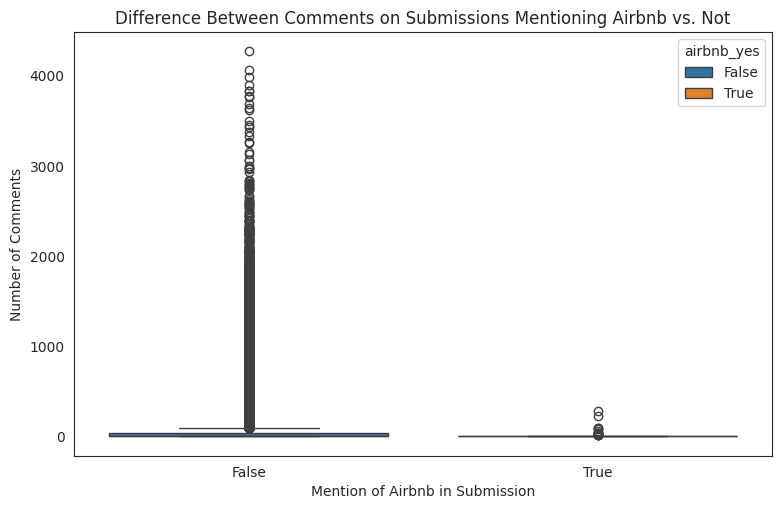

In [57]:
# reddit_df[reddit_df.loc[:,'airbnb_yes']].num_comments.plot(kind = 'box')
sns.set_style("white")
fig, ax = plt.subplots(figsize=(9,5.5))

sns.boxplot(data = reddit_df[reddit_df.num_comments < 100],
            x = 'airbnb_yes',
            y = 'num_comments',
            hue = 'airbnb_yes')

ax.set_title("Difference Between Comments on Submissions Mentioning Airbnb vs. Not")
ax.set_ylabel("Number of Comments")
ax.set_xlabel("Mention of Airbnb in Submission")

Text(0.5, 0, 'Mention of Airbnb in Submission')

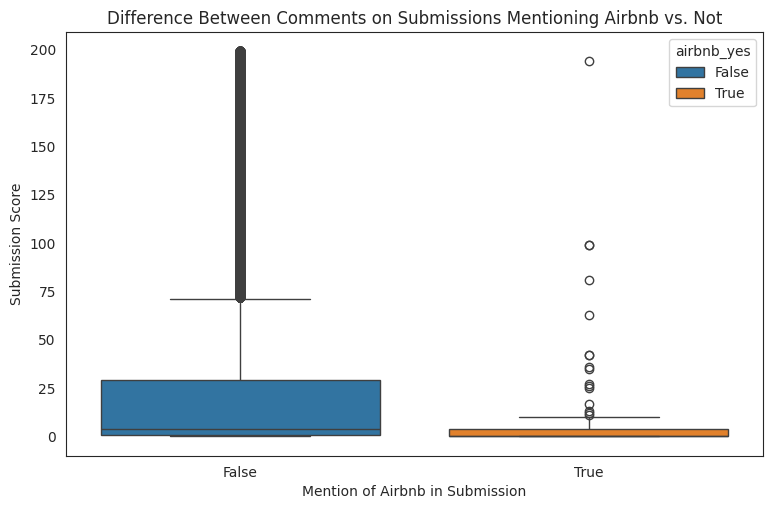

In [61]:
# reddit_df[reddit_df.loc[:,'airbnb_yes']].num_comments.plot(kind = 'box')
sns.set_style("white")
fig, ax = plt.subplots(figsize=(9,5.5))

upperbound_outlier = 200

sns.boxplot(data = reddit_df[reddit_df.score < upperbound_outlier],
            x = 'airbnb_yes',
            y = 'score',
            hue = 'airbnb_yes')

ax.set_title("Difference Between Comments on Submissions Mentioning Airbnb vs. Not")
ax.set_ylabel("Submission Score")
ax.set_xlabel("Mention of Airbnb in Submission")

# Summary Table About Regex Dummy Vars

In [64]:
regex_cols = ['airbnb_yes' ,'rent_yes', 'gentrification_yes' ,'transit_yes', 'tourist_yes']

keyword_counts = reddit_df.groupby(regex_cols).size().reset_index()
keyword_counts = keyword_counts.rename({0: 'Number of Submissions w/ Keyword'}, axis = 'columns')
keyword_counts.loc[:, 'Keyword'] = keyword_counts[regex_cols].apply(lambda row: row.columns)


,airbnb_yes,rent_yes,gentrification_yes,transit_yes,tourist_yes,Number of Submissions w/ Keyword
0,False,False,False,False,False,119854
1,False,False,False,False,True,233
2,False,False,False,True,False,375
3,False,False,False,True,True,2
4,False,False,True,False,False,11
5,False,False,True,False,True,2
6,False,True,False,False,False,4878
7,False,True,False,False,True,46
8,False,True,False,True,False,132
9,False,True,False,True,True,8


In [78]:
def combine_keywords(row):
    keyword_str = []
    for i in ['airbnb_yes' ,'rent_yes', 'gentrification_yes' ,'transit_yes', 'tourist_yes']:
        if row[i]:
            keyword_str.append(i[:i.index("_")])
    if keyword_str == []:
        keyword_str = 'does not contain any keywords'
    else:
        keyword_str = ', '.join(keyword_str)
    return keyword_str

keyword_counts.loc[:, 'Keyword Included'] = keyword_counts[regex_cols].apply(lambda row: combine_keywords(row), axis = 'columns')
keyword_counts = keyword_counts[['Keyword Included', 'Number of Submissions w/ Keyword']]
keyword_counts = keyword_counts.sort_values(by = 'Number of Submissions w/ Keyword', ascending = False)
keyword_counts

,Keyword Included,Number of Submissions w/ Keyword
0,does not contain any keywords,119854
6,rent,4878
2,transit,375
1,tourist,233
8,"rent, transit",132
12,airbnb,72
7,"rent, tourist",46
14,"airbnb, rent",36
4,gentrification,11
9,"rent, transit, tourist",8
